In [33]:
import os

initial_images_path = "img_set2_wa"

images = os.listdir(initial_images_path)
print(images)

['d01dc370f3f6b33a9e053908133f4f31.jpeg', '39638046684_b29eab721e_b.jpeg', '40706644393_5f532dd33b_b.jpeg', 'I0000Kun8CBKAlsg.jpeg', 'western-hemlock-tsuga-heterophylla-20625497.jpg.webp', 'apiyl3xs7__33833.jpeg']


In [34]:
from PIL import Image
resized_images = []
for img in images:
    image = initial_images_path + "/" + img
    im = Image.open(image)
    im_resize = im.resize(
        (400, 400)
    )
    resized_images.append(im_resize)

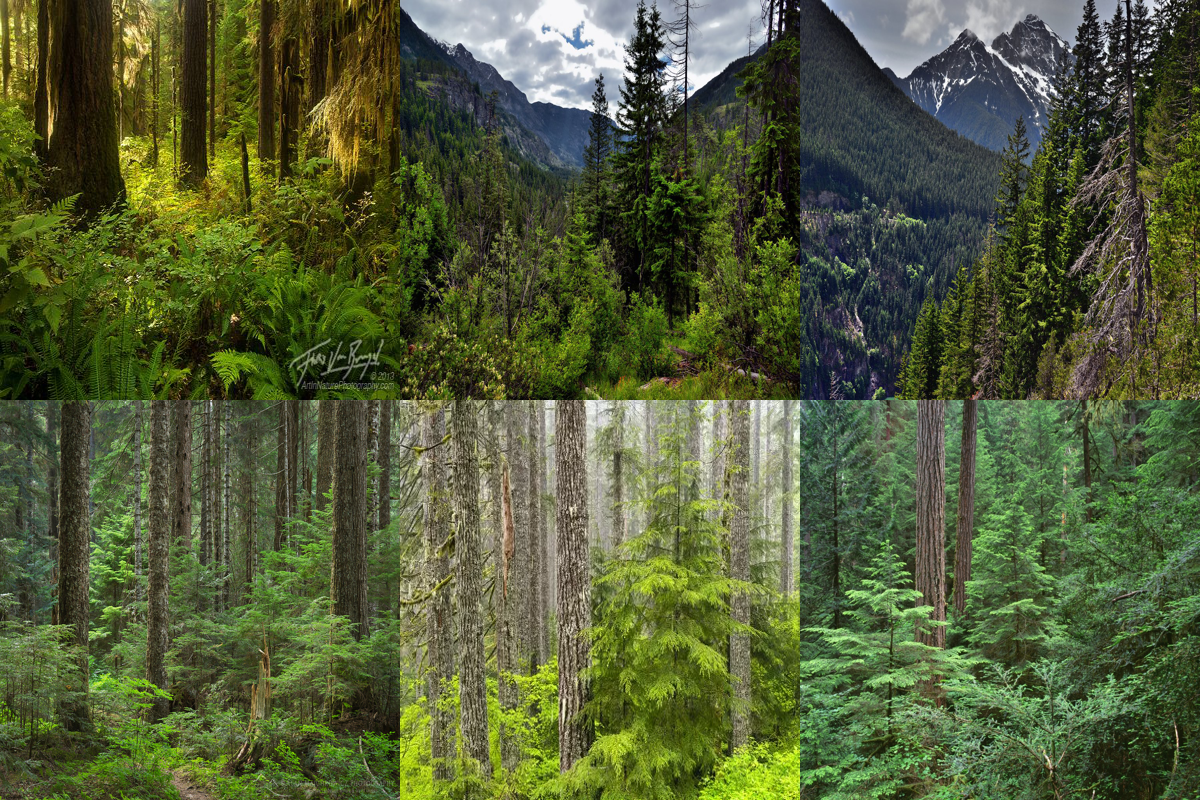

In [35]:
import random
import math

aspect = 1.77  # Aspect ratio of the output image

cols = int(math.sqrt(len(images) * aspect))
rows = int(math.ceil(float(len(images)) / float(cols)))

random.shuffle(images)
(w, h) = (400, 400)

(width, height) = (w * cols, h * rows)

collage = Image.new("RGB", (width, height))
for y in range(rows):
    for x in range(cols):
        i = y * cols + x
        # Fill in extra images by duplicating some images randomly
        if i >= len(images):
            i = random.randrange(len(images))
        collage.paste(resized_images[i], (x * w, y * h))

display(collage)

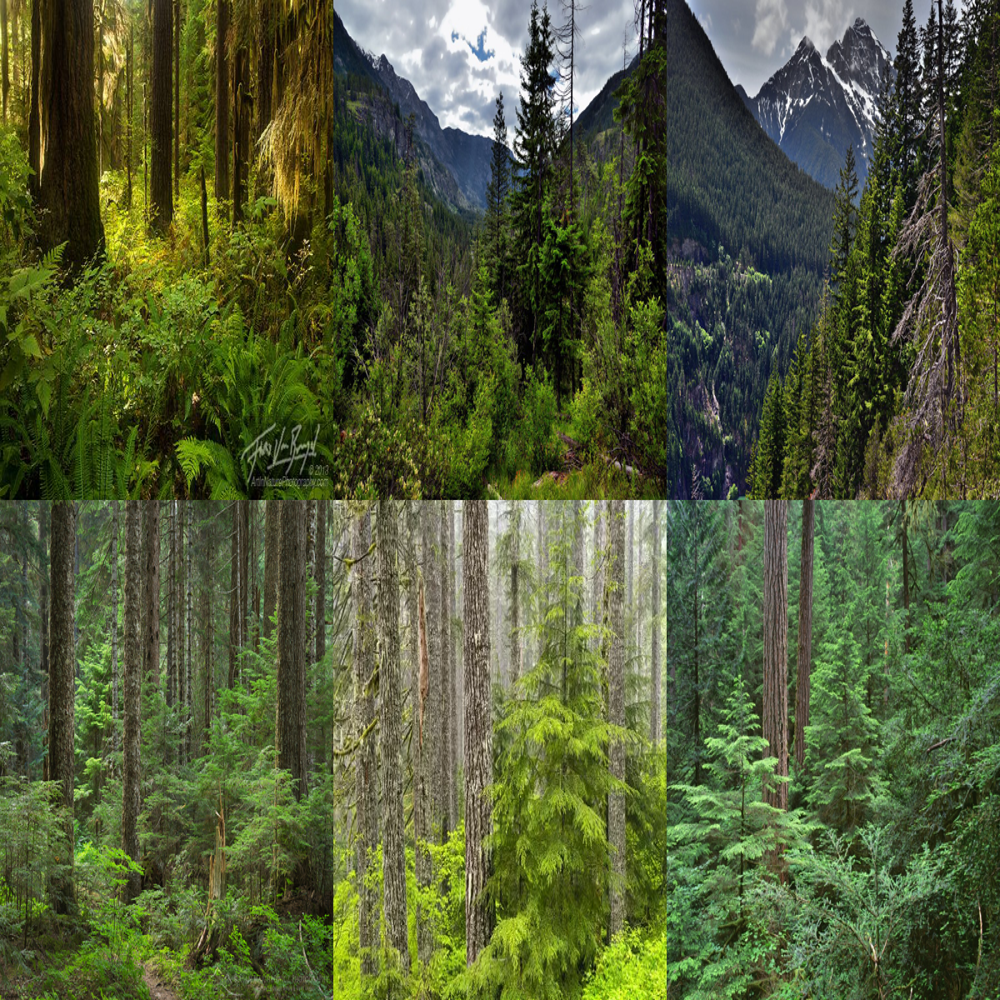

In [36]:
collage_im_resize = collage.resize(
    (1000, 1000)
)
display(collage_im_resize)

In [37]:
import numpy as np
from opensimplex import OpenSimplex
from noise import pnoise2
import time

def generateRandomNoise():

    (w, h) = (1000,1000)
    num_samples = w * h

    # for pix in num_samples:
    return np.random.random(size=num_samples)


def generateSimplexNoise():

    (w, h) = (1000,1000)

    arr = []
    simp = OpenSimplex(seed=int(time.time()))

    for y in range(0, h):
        for x in range(0, w):
            arr.append(simp.noise2(x / 40, y / 40))

    return arr


def generatePerlinNoise():

    (w, h) = (1000,1000)

    octaves = 10
    freq = 30.0 * octaves

    arr = []

    for y in range(0, h):
        for x in range(0, w):
            arr.append(pnoise2(x / freq, y / freq, octaves))

    return arr

In [38]:
def generateNoiseImage():

    (w, h) = (1000, 1000)
    num_samples = w * h
    final_values = []

    random = generateRandomNoise()
    perlin = generatePerlinNoise()
    simplex = generateSimplexNoise()

    static_val = np.empty(num_samples)
    static_val.fill(0.5)

    static_val2 = np.empty(num_samples)
    static_val2.fill(1.0)

    for a in range(0, w * h):
        final_values.append(
            (
                (random[a] * 0.02)
                + (((simplex[a] / 2) + 0.5) * 0.48)
                + (((perlin[a] / 2) + 0.5) * 0.5)
            )
            / 3
        )

    h_samples = np.reshape(np.asarray(final_values), (w, h))
    s_samples = np.reshape(static_val, (w, h))
    v_samples = np.reshape(static_val2, (w, h))

    hsv_img = np.dstack([h_samples, s_samples, v_samples])

    image = Image.fromarray(np.uint8(hsv_img * 255), mode="HSV").convert("RGB")
    image = image.quantize(colors=12)
    image.convert(mode="RGB")

    return image

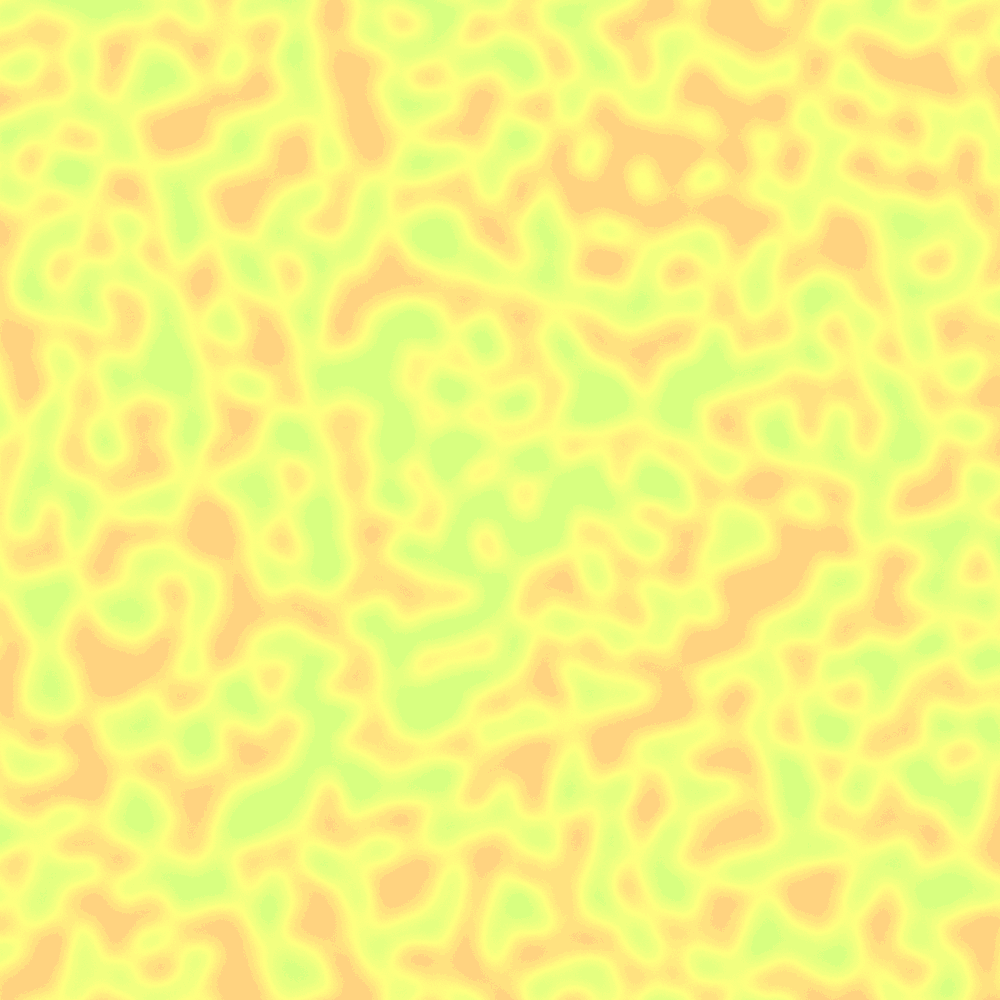

In [39]:
noise_image = generateNoiseImage()

display(noise_image)

In [40]:
from colorthief import ColorThief
import numpy as np
from PIL import Image
import io

with io.BytesIO() as file_object:
    collage_im_resize.save(file_object, "PNG")
    color_thief = ColorThief(file_object)

    # https://stackoverflow.com/questions/56069551/trying-to-display-list-of-rgb-values
    barColors = color_thief.get_palette(color_count=24, quality=1)
    barColors = (np.array(barColors)).astype(np.uint8)
    cols = len(barColors)
    rows = max([1, int(cols / 2.5)])

    # Create color Array
    barFullData = np.tile(barColors, (rows, 1)).reshape(rows, cols, 3)
    # Create Image from Array
    barImg = Image.fromarray(barFullData, "RGB")

    print(barColors)
    display(barImg)

[[196 200 192]
 [101 135  65]
 [143 183  82]
 [137 140  89]
 [100 101  56]
 [147 154 168]
 [ 75 100  45]
 [ 85  94 109]
 [ 61  68  74]
 [185 200  49]
 [ 15  20  15]
 [161 173 188]
 [ 38  40  16]
 [189 188 103]
 [ 78  75  39]
 [ 61  79  32]
 [ 62  60  29]
 [ 47  53  55]
 [ 47  63  23]
 [ 29  19  11]
 [ 42  44  38]
 [172  92  76]
 [128  68  24]]


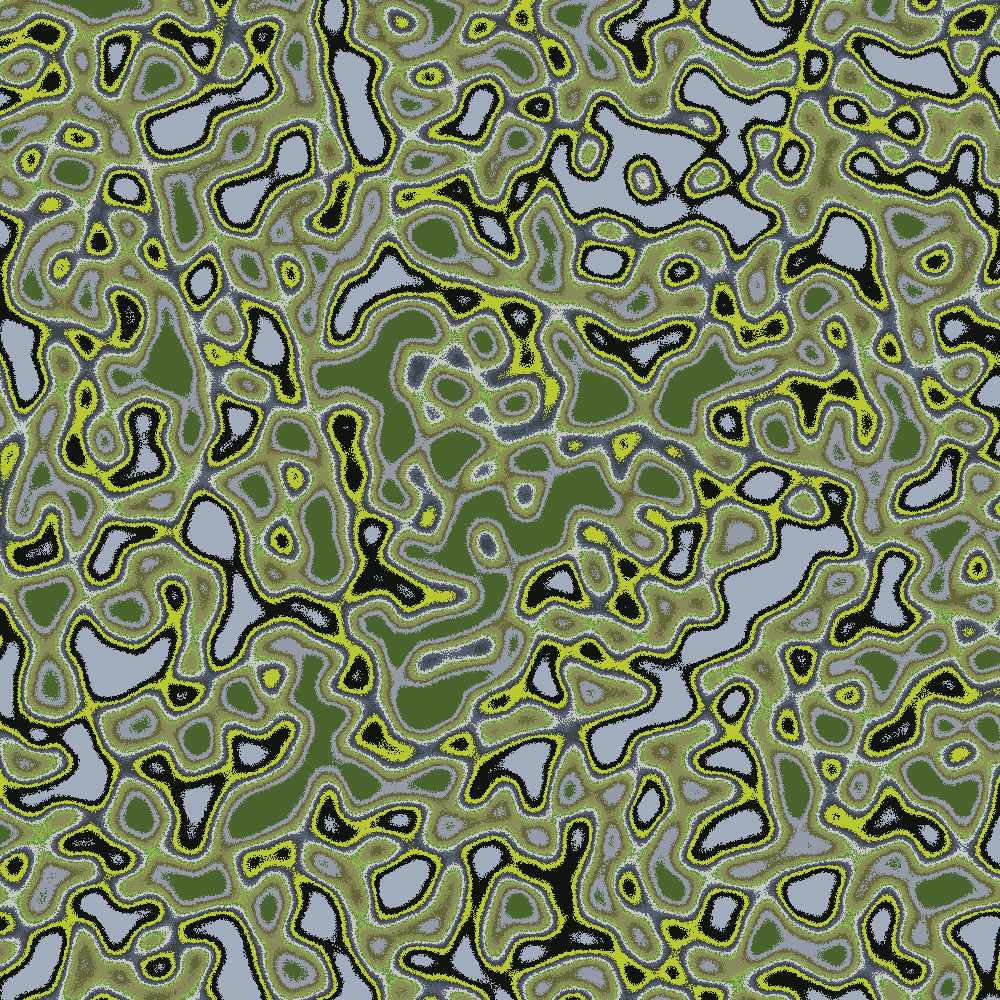

In [41]:
swapped_colors = noise_image.convert("P")
swapped_colors.putpalette(barColors)

display(swapped_colors)

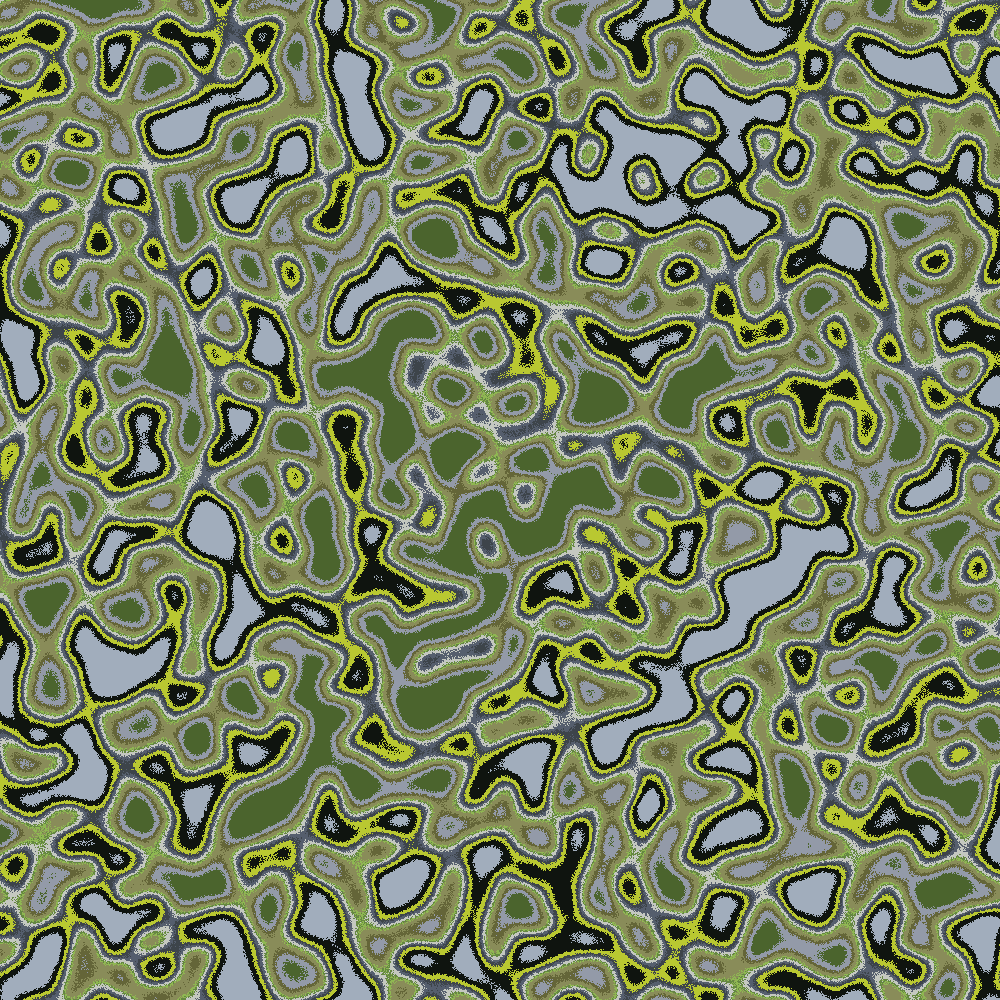

In [42]:
quantized_swapped_colors = swapped_colors.quantize(colors=16)

display(quantized_swapped_colors)

Tessellating: 100%|██████████| 1000/1000 [09:49<00:00,  1.70it/s]


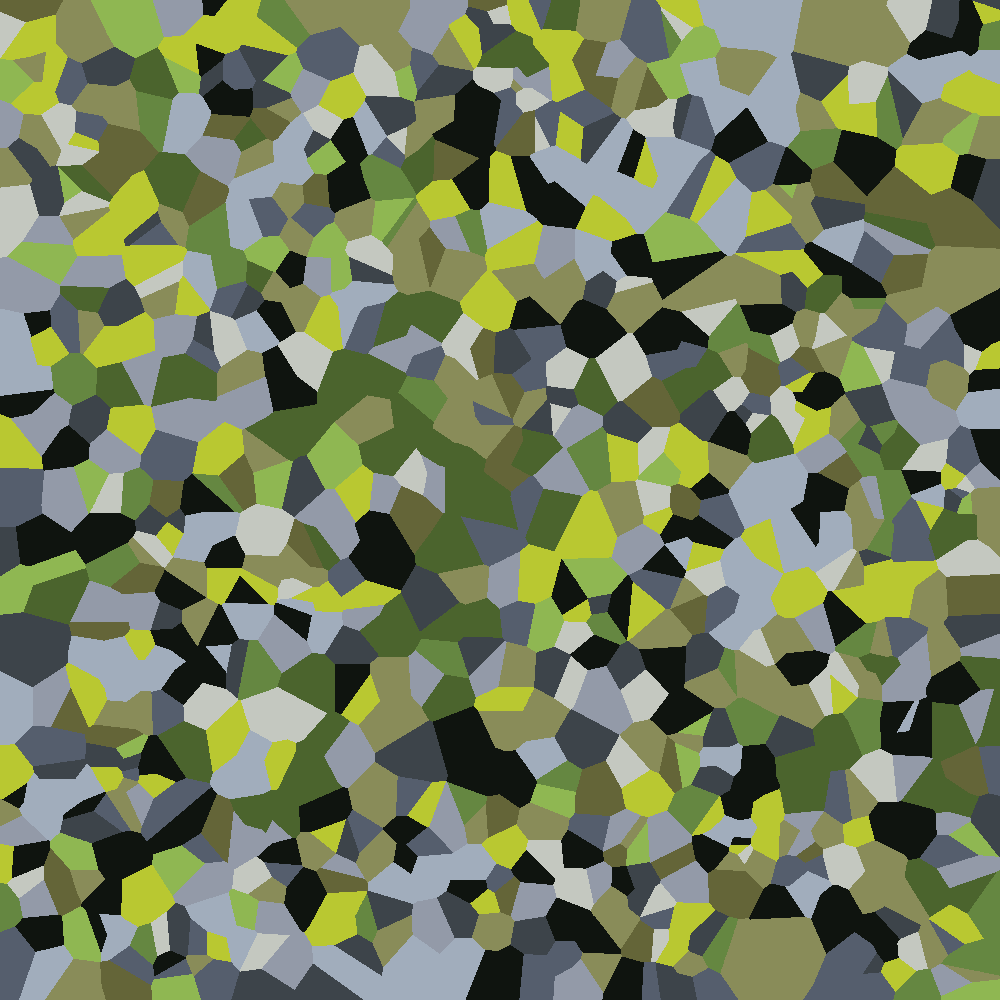

In [43]:
from tqdm import tqdm

height = 1000
width = 1000
num_cells = 1000

rgbbase = quantized_swapped_colors.convert("RGB")
first_voronoi = Image.new("RGB", (width, height))
putpixel = first_voronoi.putpixel
imgx, imgy = first_voronoi.size
nx = []
ny = []
nr = []
ng = []
nb = []
for i in tqdm(range(num_cells), desc="Creating Points"):
    nx.append(random.randrange(1, imgx))
    ny.append(random.randrange(1, imgy))
    rgb = rgbbase.getpixel((nx[i], ny[i]))
    nr.append(rgb[0])
    ng.append(rgb[1])
    nb.append(rgb[2])
for y in tqdm(range(imgy), desc="Tessellating"):
    for x in range(imgx):
        dmin = math.hypot(imgx - 1, imgy - 1)
        j = -1
        for i in range(num_cells):
            d = math.hypot(nx[i] - x, ny[i] - y)
            if d < dmin:
                dmin = d
                j = i
        putpixel((x, y), (nr[j], ng[j], nb[j]))

display(first_voronoi)

In [44]:
with io.BytesIO() as file_object:
    first_voronoi.save(file_object, "PNG")
    color_thief = ColorThief(file_object)

    # https://stackoverflow.com/questions/56069551/trying-to-display-list-of-rgb-values
    single_color = color_thief.get_color(quality=1)
    print(single_color)

(30, 38, 36)


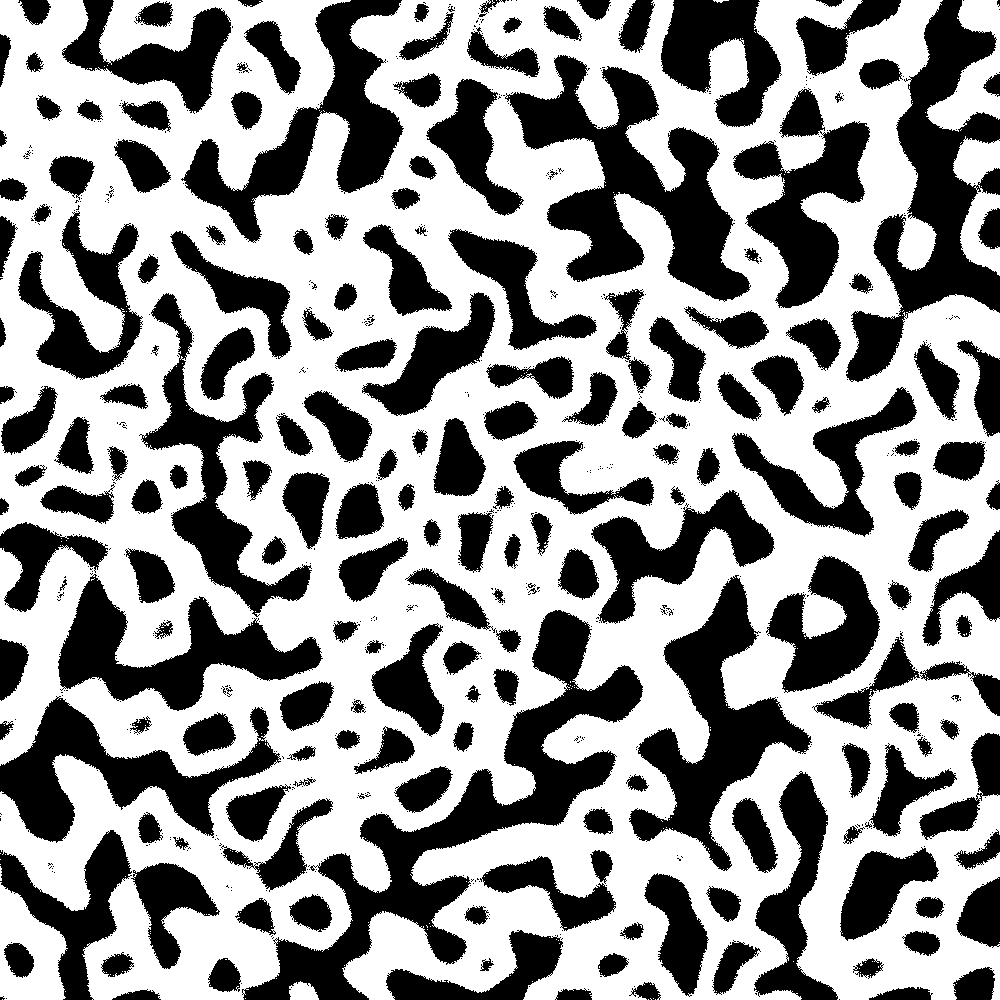

In [45]:
new_noise = generateNoiseImage()
thresh = 230
fn = lambda x : 255 if x > thresh else 0
r = new_noise.convert('L').point(fn, mode='1')

display(r)

Tessellating: 100%|██████████| 1000/1000 [13:13<00:00,  1.26it/s]


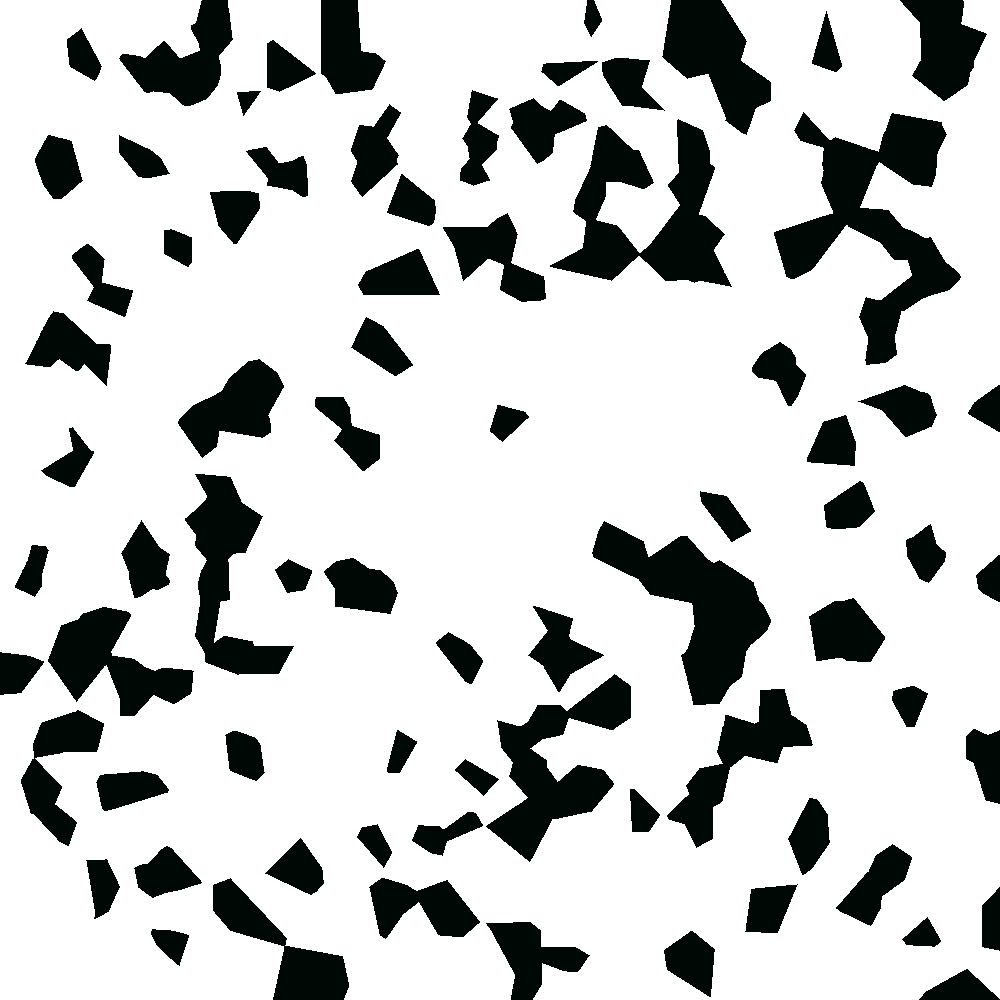

In [46]:
height = 1000
width = 1000
num_cells = 1000
tmp_thresh = 8
darkness = 30

if single_color[0] - darkness > 0:
    single_color_dark_r = single_color[0] - darkness
else:
    single_color_dark_r = 0

if single_color[1] - darkness > 0:
    single_color_dark_g = single_color[1] - darkness
else:
    single_color_dark_g = 0

if single_color[2] - darkness > 0:
    single_color_dark_b = single_color[2] - darkness
else:
    single_color_dark_b = 0

single_color_dark = (single_color_dark_r, single_color_dark_g, single_color_dark_b)

second_voronoi = Image.new("RGBA", (width, height))

putpixel = second_voronoi.putpixel
imgx, imgy = second_voronoi.size
nx = []
ny = []
nr = []
ng = []
nb = []
na = []
for i in tqdm(range(num_cells), desc="Creating Points"):
    nx.append(random.randrange(1, imgx))
    ny.append(random.randrange(1, imgy))
    bw = new_noise.getpixel((nx[i], ny[i]))
    nr.append(single_color_dark[0])
    ng.append(single_color_dark[1])
    nb.append(single_color_dark[2])  
    if bw > tmp_thresh:
        na.append(255)
    else:
        na.append(0)

for y in tqdm(range(imgy), desc="Tessellating"):
    for x in range(imgx):
        dmin = math.hypot(imgx - 1, imgy - 1)
        j = -1
        for i in range(num_cells):
            d = math.hypot(nx[i] - x, ny[i] - y)
            if d < dmin:
                dmin = d
                j = i
        putpixel((x, y), (nr[j], ng[j], nb[j], na[j]))

display(second_voronoi)

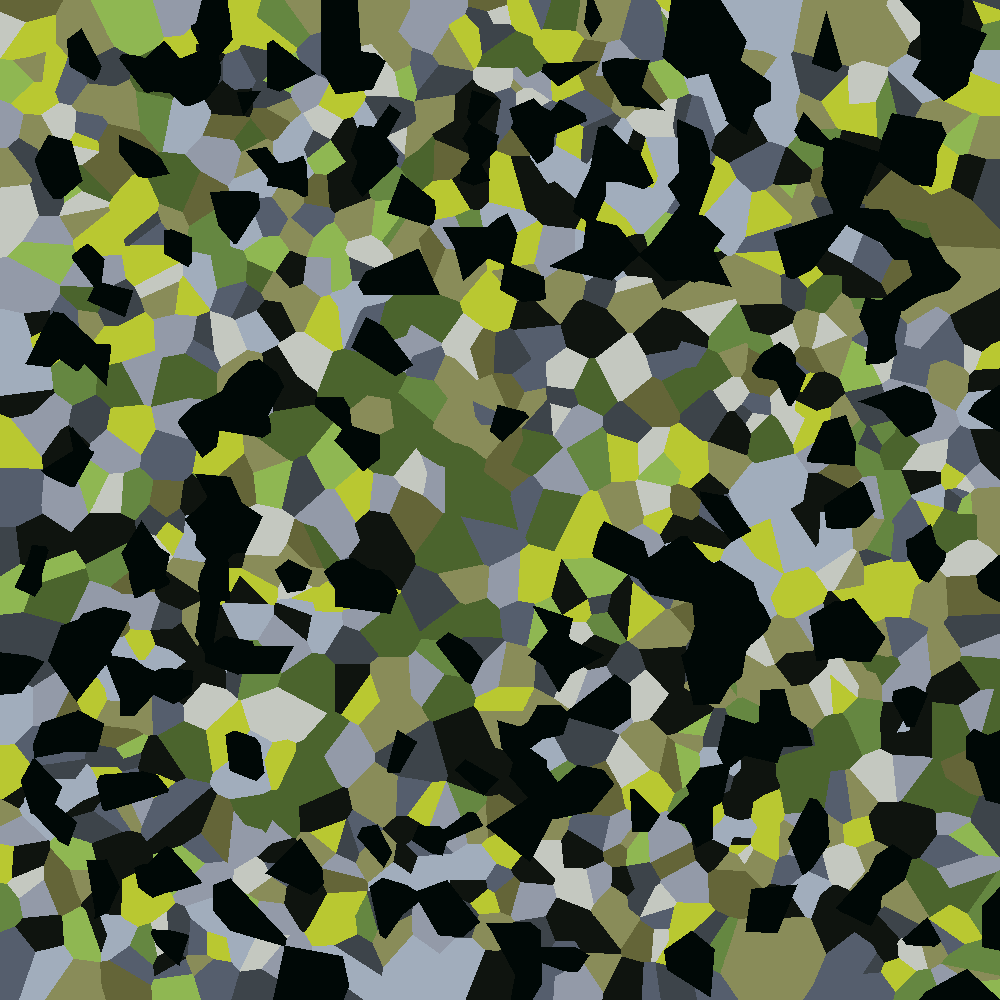

In [47]:
import copy
bg = copy.deepcopy(first_voronoi)
bg.paste(second_voronoi, (0, 0), second_voronoi)
display(bg)

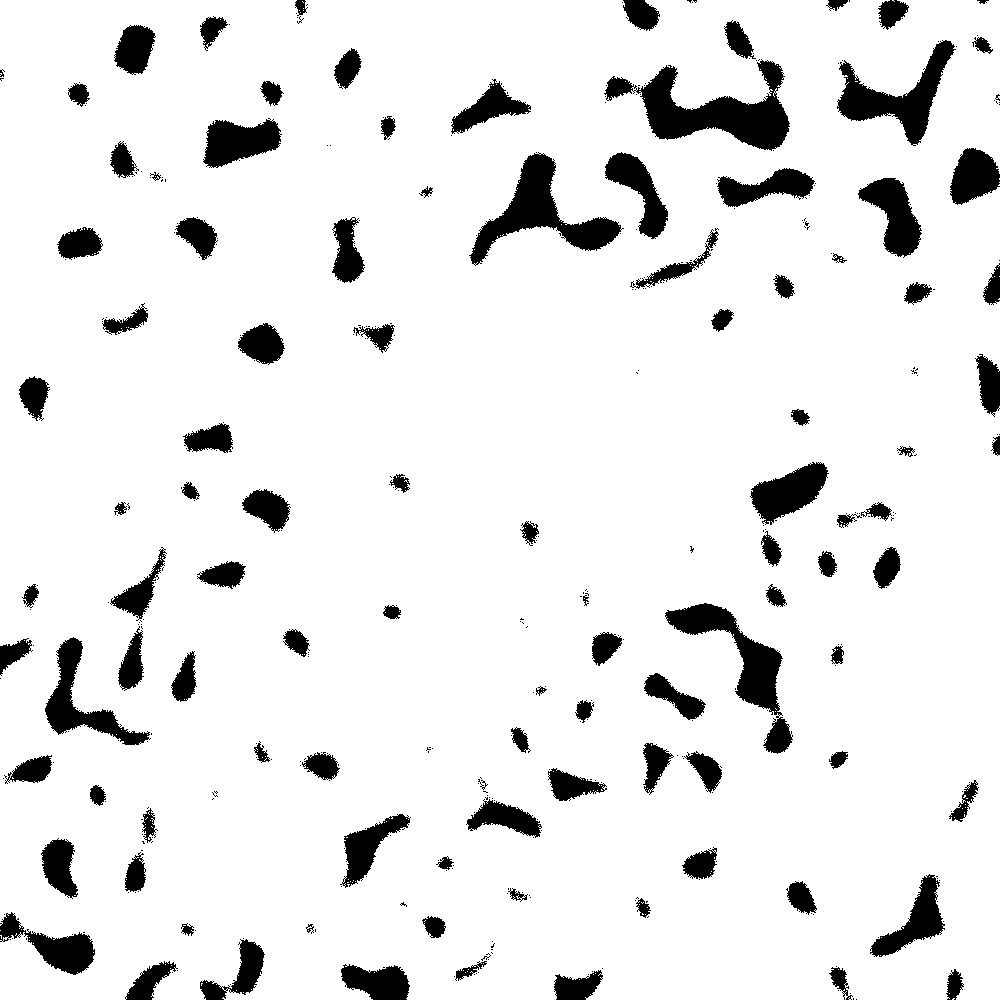

In [48]:
new_noise = generateNoiseImage()
thresh = 222
fn = lambda x : 255 if x > thresh else 0
r = new_noise.convert('L').point(fn, mode='1')

display(r)

Tessellating: 100%|██████████| 1000/1000 [15:42<00:00,  1.06it/s]


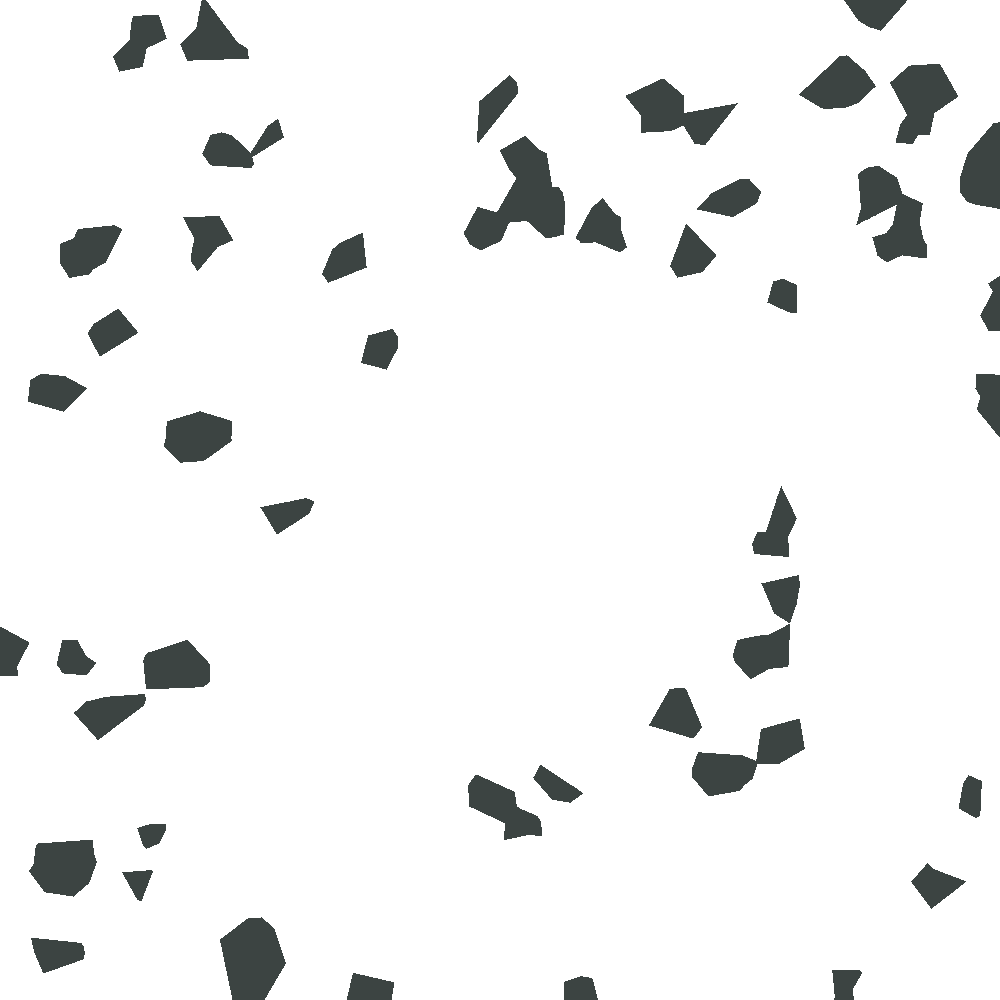

In [52]:
height = 1000
width = 1000
num_cells = 1000
tmp_thresh = 10
lightness = 30

if single_color[0] + lightness < 255:
    single_color_light_r = single_color[0] + lightness
else:
    single_color_light_r = 255

if single_color[1] - darkness < 255:
    single_color_light_g = single_color[1] + lightness
else:
    single_color_light_g = 255

if single_color[2] - darkness < 255:
    single_color_light_b = single_color[2] + lightness
else:
    single_color_light_b = 255

single_color_light = (single_color_light_r, single_color_light_g, single_color_light_b)

third_voronoi = Image.new("RGBA", (width, height))

putpixel = third_voronoi.putpixel
imgx, imgy = third_voronoi.size
nx = []
ny = []
nr = []
ng = []
nb = []
na = []
for i in tqdm(range(num_cells), desc="Creating Points"):
    nx.append(random.randrange(1, imgx))
    ny.append(random.randrange(1, imgy))
    bw = new_noise.getpixel((nx[i], ny[i]))
    nr.append(single_color_light[0])
    ng.append(single_color_light[1])
    nb.append(single_color_light[2])  
    if bw > tmp_thresh:
        na.append(255)
    else:
        na.append(0)

for y in tqdm(range(imgy), desc="Tessellating"):
    for x in range(imgx):
        dmin = math.hypot(imgx - 1, imgy - 1)
        j = -1
        for i in range(num_cells):
            d = math.hypot(nx[i] - x, ny[i] - y)
            if d < dmin:
                dmin = d
                j = i
        putpixel((x, y), (nr[j], ng[j], nb[j], na[j]))

display(third_voronoi)

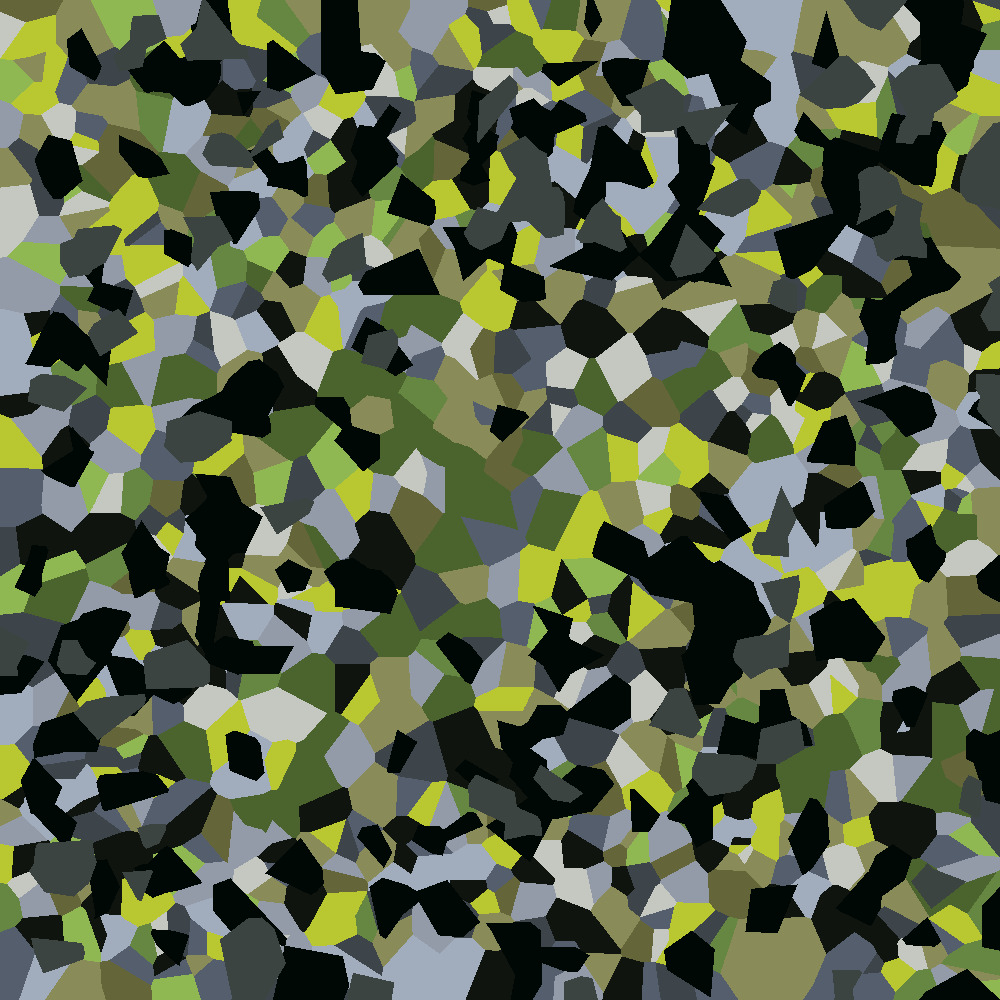

In [53]:
import copy
bg2 = copy.deepcopy(bg)
bg2.paste(third_voronoi, (0, 0), third_voronoi)
display(bg2)